In [8]:
!git clone https://github.com/anushka-s/Image-restoration-using-deep-image-prior.git
!mv Image-restoration-using-deep-image-prior/* ./

fatal: destination path 'Image-restoration-using-deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'Image-restoration-using-deep-image-prior/*': No such file or directory


In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [10]:
## denoising
fname = '/content/data/denoising/F16_GT.png'

In [12]:
img_pil.size

(512, 512)

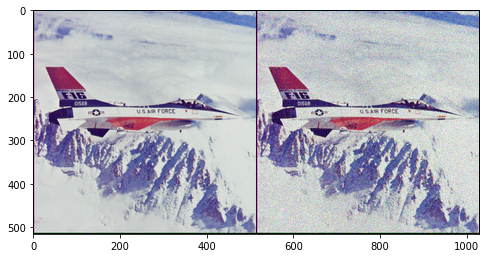

In [11]:
if fname == '/content/data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

class Model_Down(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self,in_channels, nd = 128, kd = 3, padding = 1, stride = 2):
        super(Model_Down,self).__init__()
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nd, kernel_size = kd, stride = stride)
        self.bn1 = nn.BatchNorm2d(nd)

        self.conv2 = nn.Conv2d(in_channels = nd, out_channels = nd, kernel_size = kd, stride = 1)
        self.bn2 = nn.BatchNorm2d(nd)

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.padder(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class Model_Skip(nn.Module):
    """

    Skip Connections

    ns = Number of filters
    ks = Kernel size

    """
    def __init__(self,in_channels = 128, ns = 4, ks = 1, padding = 0, stride = 1):
        super(Model_Skip, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = ns, kernel_size = ks, stride = stride, padding = padding)
        self.bn = nn.BatchNorm2d(ns)
        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Model_Up(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self, in_channels = 132, nu = 128, ku = 3, padding = 1):
        super(Model_Up, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nu, kernel_size = ku, stride = 1, padding = 0)
        self.bn2 = nn.BatchNorm2d(nu)

        self.conv2 =  nn.Conv2d(in_channels = nu, out_channels = nu, kernel_size = 1, stride = 1, padding = 0) #According to supmat.pdf ku = 1 for second layer
        self.bn3 = nn.BatchNorm2d(nu)

        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.bn1(x)
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor = 2, mode = 'bilinear')
        return x


class Model(nn.Module):
    def __init__(self, length = 5, in_channels = 32, out_channels = 3, nu = [128,128,128,128,128] , nd =
                    [128,128,128,128,128], ns = [4,4,4,4,4], ku = [3,3,3,3,3], kd = [3,3,3,3,3], ks = [1,1,1,1,1]):
        super(Model,self).__init__()
        assert length == len(nu), 'Hyperparameters do not match network depth.'

        self.length = length

        self.downs = nn.ModuleList([Model_Down(in_channels = nd[i-1], nd = nd[i], kd = kd[i]) if i != 0 else
                                        Model_Down(in_channels = in_channels, nd = nd[i], kd = kd[i]) for i in range(self.length)])

        self.skips = nn.ModuleList([Model_Skip(in_channels = nd[i], ns = ns[i], ks = ks[i]) for i in range(self.length)])

        self.ups = nn.ModuleList([Model_Up(in_channels = ns[i]+nu[i+1], nu = nu[i], ku = ku[i]) if i != self.length-1 else
                                        Model_Up(in_channels = ns[i], nu = nu[i], ku = ku[i]) for i in range(self.length-1,-1,-1)]) #Elements ordered backwards

        self.conv_out = nn.Conv2d(nu[0],out_channels,1,padding = 0)
        self.sigm = nn.Sigmoid()

    def forward(self,x):
        s = [] #Skip Activations

        #Downpass
        for i in range(self.length):
            x = self.downs[i].forward(x)
            s.append(self.skips[i].forward(x))

        #Uppass
        for i in range(self.length):
            if (i == 0):
                x = self.ups[i].forward(s[-1])
            else:
                x = self.ups[i].forward(torch.cat([x,s[self.length-1-i]],axis = 1))

        x = self.sigm(self.conv_out(x)) #Squash to RGB ([0,1]) format
        return x


In [20]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER= 'adam'
show_every = 100
exp_weight=0.99

if fname == '/content/data/denoising/F16_GT.png':
    num_iter = 1000
    input_depth = 3
    figsize = 3 
    
    
    net = Model(in_channels = 3, out_channels = 3).to(device)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach().to(device)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype).to(device)

Number of params: 2037095


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_r



After 0 iterations: 
Iteration 00000    Loss 0.101514   PSNR_noisy: 9.934745   PSRN_gt: 10.308767   PSNR_gt_sm: 10.308767 


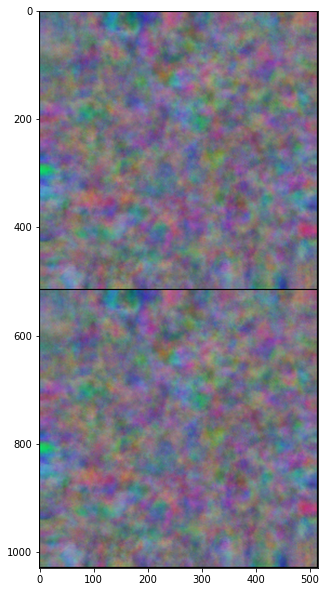



After 100 iterations: 
Iteration 00100    Loss 0.020574   PSNR_noisy: 16.866883   PSRN_gt: 19.370943   PSNR_gt_sm: 15.941624 


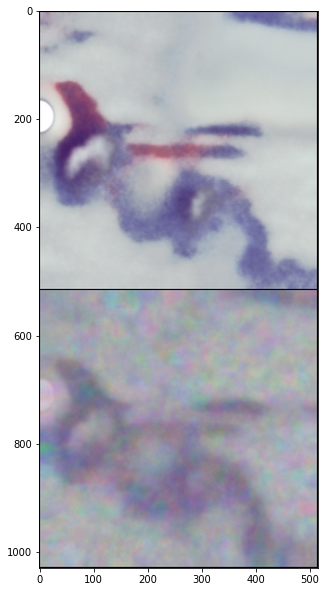



After 200 iterations: 
Iteration 00200    Loss 0.016490   PSNR_noisy: 17.827740   PSRN_gt: 21.305871   PSNR_gt_sm: 19.829895 


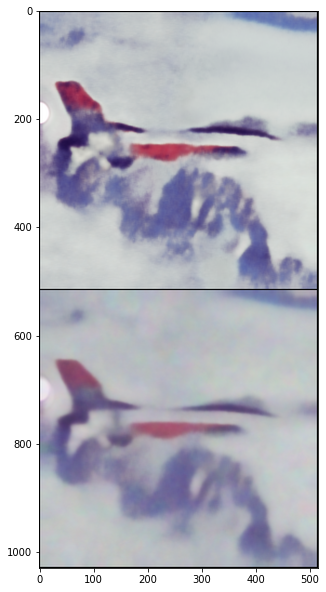



After 300 iterations: 
Iteration 00300    Loss 0.014601   PSNR_noisy: 18.356115   PSRN_gt: 22.575509   PSNR_gt_sm: 21.973736 


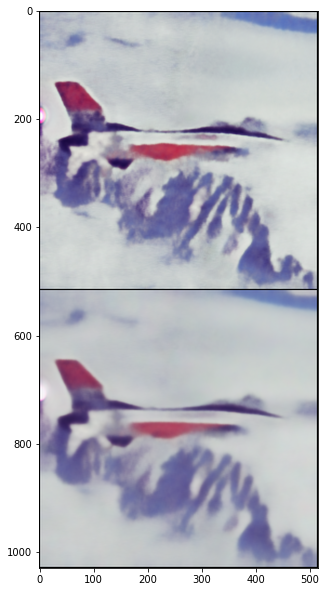



After 400 iterations: 
Iteration 00400    Loss 0.013421   PSNR_noisy: 18.722074   PSRN_gt: 23.622943   PSNR_gt_sm: 23.368234 


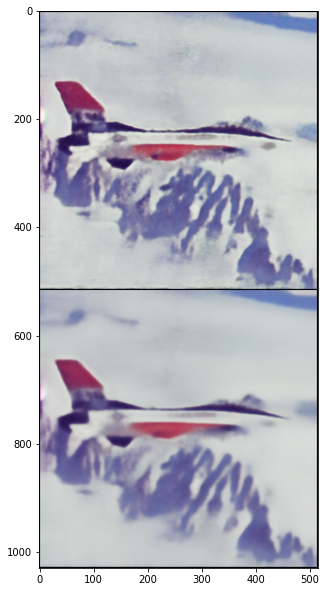



After 500 iterations: 
Iteration 00500    Loss 0.012801   PSNR_noisy: 18.927445   PSRN_gt: 24.282927   PSNR_gt_sm: 24.510008 


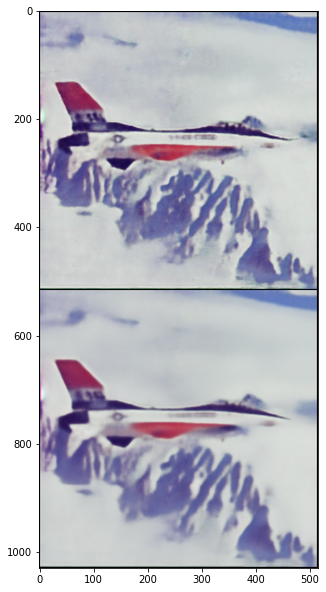



After 600 iterations: 
Iteration 00600    Loss 0.012134   PSNR_noisy: 19.159842   PSRN_gt: 25.131211   PSNR_gt_sm: 25.416272 


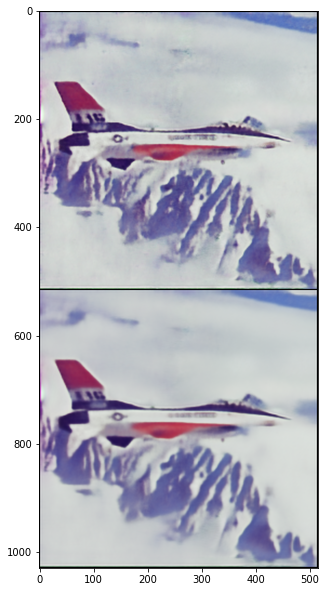



After 700 iterations: 
Iteration 00700    Loss 0.011772   PSNR_noisy: 19.291638   PSRN_gt: 25.676883   PSNR_gt_sm: 26.204213 


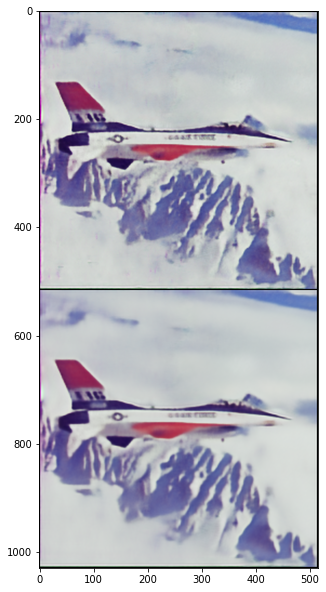



After 800 iterations: 
Iteration 00800    Loss 0.011346   PSNR_noisy: 19.451679   PSRN_gt: 26.410312   PSNR_gt_sm: 26.912533 


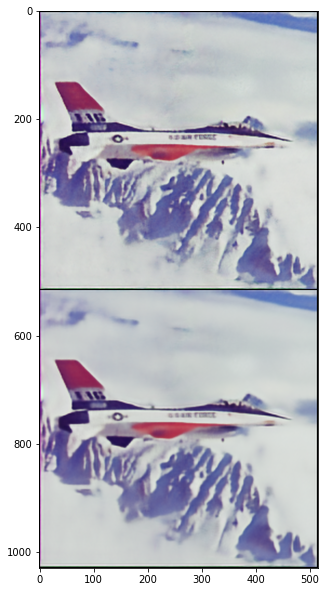



After 900 iterations: 
Iteration 00900    Loss 0.011078   PSNR_noisy: 19.555516   PSRN_gt: 26.872670   PSNR_gt_sm: 27.456616 


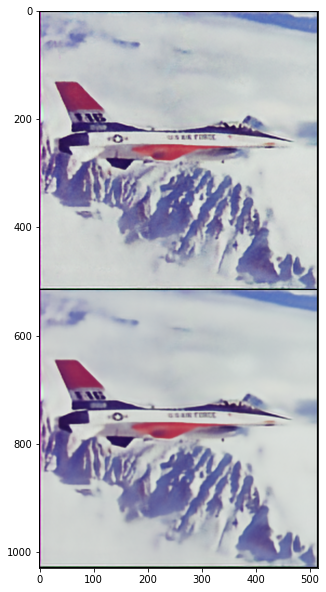

In [21]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
loss = []

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, loss
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std) #changing the input to the netwok
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight) # calculating average network output
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    loss.append(total_loss.item())
        
    
    # caculating psrn
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the actual noisy image 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the original image 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) # comparing psnr for the output average and the original image 
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # plotting the output image along the average image calculated
        print(f'\n\nAfter {i} iterations: ')
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f   PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='\n')
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

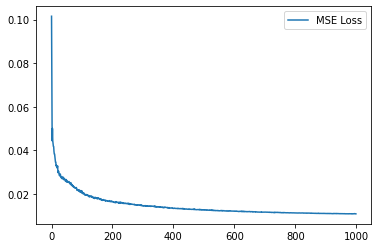

In [22]:
# Plotting the loss as a function of number of iterations
itr = [i for i in range(num_iter)]
plt.plot(itr, loss, )
plt.legend(['MSE Loss'])
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Output Image from the network: 


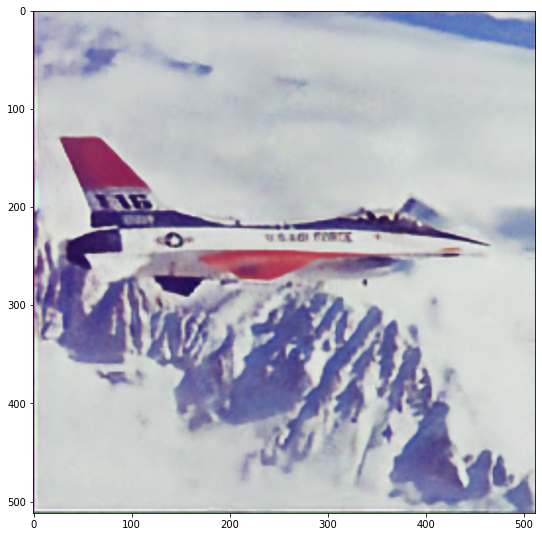


Noised Image: 


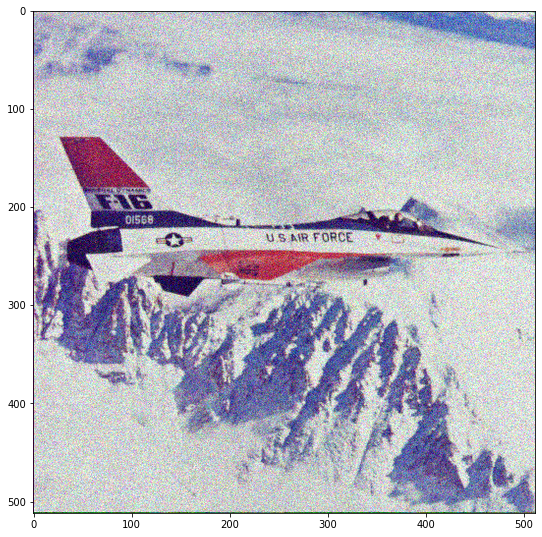


Original Image: 


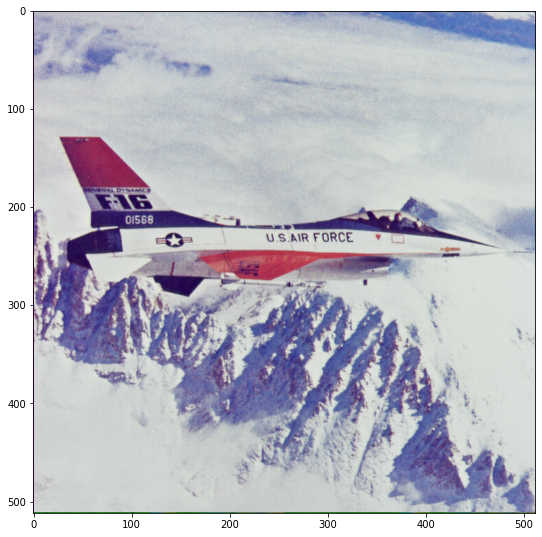

In [23]:
out_np = torch_to_np(net(net_input))

print('Output Image from the network: ')
plot_image_grid([np.clip(out_np, 0, 1)], factor=8);

print('\nNoised Image: ')
plot_image_grid([img_noisy_np], factor=8);

print('\nOriginal Image: ')
plot_image_grid([img_np], factor=8);